## Tarea de Merge Trees

In [16]:
# Importar paquetes
import merger_tree_tools as mtt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo
import h5py
import os
import pandas as pd

In [17]:
# Simulación a usar y datos de galaxia deseada
simu='RefL0100N1504'

snap=28
galid=21379521

In [18]:
# Usuario y contraseña para conectarse a EAGLE DataBase
usr='cht015'
pwd='BH457tfj'

# Descargar todos los IDS necesarios de la galaxia deseada

myIDs=mtt.retrieve_ids(usr,pwd,simu,snap,galid)

# Descargar merger tree completo de la galaxia deseada
# Nombre y alias de la tabla de la cual se quieren descargar datos
table='SubHalo'
table_alias='sub'

# Variables que se quiere descargar. OJO!! Asegurarse que estas variables
# estén en la tabla deseada.
columns=[
         'GalaxyID','LastProgID','TopLeafID','DescendantID',
         'SnapNum','Redshift','Stars_Mass','SF_Mass','SF_Hydrogen','SF_Oxygen',
         'StarFormationRate','Stars_Metallicity'
        ]

raw_tree=mtt.download_merger_tree(usr,pwd,simu,myIDs['GalaxyID'],myIDs['LastProgID'],
                                  table=table,table_alias=table_alias,columns=columns)

# NOTA: si ya se tiene descargados en un archivo todas las galaxias de la simu, se puede
#       saltear esta celda, y en su lugar, leer dicho archivo de datos y usar máscaras
#       para seleccionar las galaxias del árbol deseado

In [19]:
# Aplicar condiciones a las galaxias del árbol, si es necesario
mask=(
      (raw_tree['Stars_Mass']>0e6) &
      (raw_tree['SF_Mass']>0) &
      (raw_tree['SF_Hydrogen']>0) &
      (raw_tree['SF_Oxygen']>0)
     )

In [20]:
# Armar arbol sólo con galaxias seleccionadas según condiciones anteriores
tree={}
for key in raw_tree.keys():
    tree[key]=raw_tree[key][mask]
    
print('Number of galaxies in the selected tree: '+str(len(tree['GalaxyID'])))    
    
# Ordeno las galaxias según SnapNum creciente
mask_order=(tree['SnapNum']).argsort()
for key in tree.keys():
    tree[key]=tree[key][mask_order]


Number of galaxies in the selected tree: 7826


In [21]:
# Agregar variables al árbol final, si es necesario
tree['sSFR']=tree['StarFormationRate']/tree['Stars_Mass']
tree['SF_logOH']=12+np.log10(tree['SF_Oxygen']/tree['SF_Hydrogen'])-np.log10(16)

In [22]:
# Armo un diccionario con solo la main branch del árbol
main_branch={}
# Select galaxies in the main branch 
mask_main=np.logical_and(tree['GalaxyID']>=myIDs['GalaxyID'],
                         tree['GalaxyID']<=myIDs['TopLeafID']) 

for key in tree.keys():
    main_branch[key]=tree[key][mask_main]

print('Number of galaxies in the main branch of selected tree: '+str(len(main_branch['GalaxyID'])))

Number of galaxies in the main branch of selected tree: 27


In [23]:
# Variables to plot
xplot=tree['SnapNum']
yplot=np.log10(tree['Stars_Mass'])

# Labels of variables to plot
xlabel=r'$SnapNum$'
ylabel=r'$\log(M_\bigstar)~[\rm{M}_\odot]$'

# Variable to colour markers and lines
color_var=tree['Redshift']
color_var_label='z'

# Define colors
cmap=plt.get_cmap('jet')
# Limits of variable used to color-code. Modify if necessary.
vmin=min(color_var)
vmax=max(color_var)
norm=colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
color_plot=cmap(norm(color_var))

# Variables a graficar, solo de la main branch
xplot_main=xplot[mask_main]
yplot_main=yplot[mask_main]
color_plot_main=color_plot[mask_main]



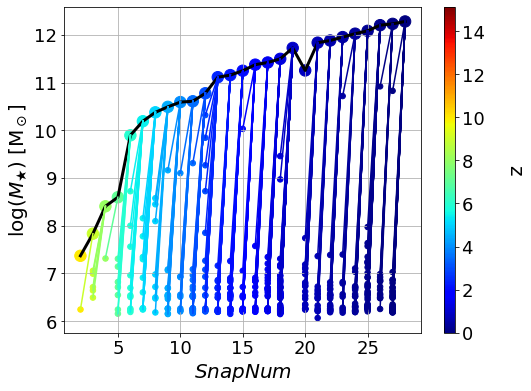

In [24]:
fig,ax=plt.subplots(figsize=(8,6))
    
# Plot main branch
ax.plot(xplot_main,yplot_main,c='k',lw=3)
sc_main=ax.scatter(xplot_main,yplot_main,c=color_plot_main,s=130)

# Vertical color bar with reference to redshifts
sc_main.set_cmap('jet')
sc_main.set_norm(norm)
cbar=fig.colorbar(sc_main, ax=ax, orientation='vertical',shrink=1,pad=0.05,aspect=30)
cbar.set_label(color_var_label,fontsize=20,rotation=270,labelpad=40)
cbar.ax.tick_params(axis='both', which='major', labelsize=18,top=True,bottom=False,
                    labeltop=True,labelbottom=False)

# -------------------------------------------------------------------------------------------

# Galaxias que se fusionan con las de la main branch
plot_main_mergers=True
if plot_main_mergers:
    for i in range(np.size(main_branch['GalaxyID'])):    
        xplot_merge=[]
        yplot_merge=[]
        color_merge=np.array([[1,1,1,1]])  # Lo inicializo así para usar luego vstack
    
        mask=np.where((tree['DescendantID']==main_branch['GalaxyID'][i]))[0]  # estas galaxias incluyen también
                                                                          # al progenitor principal.  
        # Con lo siguiente, se excluye al progenitor principal
        for k in mask:
            if tree['GalaxyID'][k] not in main_branch['GalaxyID']:
                xplot_merge=np.append(xplot_merge,xplot[k])
                yplot_merge=np.append(yplot_merge,yplot[k])
                color_merge=np.vstack((color_merge,color_plot[k]))
        color_merge=np.delete(color_merge,(0),axis=0)
        
        # Scatter plot of galaxies that merge with main branch
        ax.scatter(xplot_merge,yplot_merge,c=color_merge,s=30)
    
        # Lines matching the galaxies with their descendant
        for j in range(len(xplot_merge)):
            ax.plot([xplot_merge[j],xplot_main[i]],[yplot_merge[j],yplot_main[i]],c=color_plot_main[i])

# -------------------------------------------------------------------------------------------     
        
# Tune up the plot
ax.grid()

xmin, xmax = -0.3,8.3
#ax.set_xlim(xmax,xmin)

ymin, ymax= 6.4,10.6
#ax.set_ylim(ymin,ymax)

ax.set_xlabel(xlabel,fontsize=20)
ax.set_ylabel(ylabel,fontsize=20)

ax.tick_params(which='major',axis='both',labelsize=18)

# plt.savefig('merge_tree_log(mass)_vs_snapnum.png')

In [25]:
Graficos para la rama principal de progenitores

SyntaxError: invalid syntax (<ipython-input-25-9028998af74a>, line 1)

In [26]:
# Variables to plot
xplot=np.log10(tree['Stars_Mass'])
yplot=tree['SF_logOH']

# Labels of variables to plot
xlabel=r'$\log(M_\bigstar)~[\rm{M}_\odot]$'
ylabel=r'$12+\log(O/H)$'

# Variable to colour markers and lines
color_var=tree['Redshift']
color_var_label='z'

# Define colors
cmap=plt.get_cmap('jet')
# Limits of variable used to color-code. Modify if necessary.
vmin=min(color_var)
vmax=max(color_var)
norm=colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
color_plot=cmap(norm(color_var))

# Variables a graficar, solo de la main branch
xplot_main=xplot[mask_main]
yplot_main=yplot[mask_main]
color_plot_main=color_plot[mask_main]

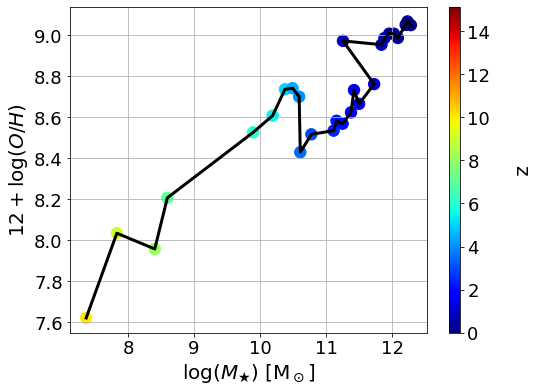

In [27]:
fig,ax=plt.subplots(figsize=(8,6))
    
# Plot main branch
ax.plot(xplot_main,yplot_main,c='k',lw=3)
sc_main=ax.scatter(xplot_main,yplot_main,c=color_plot_main,s=130)

# Vertical color bar with reference to redshifts
sc_main.set_cmap('jet')
sc_main.set_norm(norm)
cbar=fig.colorbar(sc_main, ax=ax, orientation='vertical',shrink=1,pad=0.05,aspect=30)
cbar.set_label(color_var_label,fontsize=20,rotation=270,labelpad=40)
cbar.ax.tick_params(axis='both', which='major', labelsize=18,top=True,bottom=False,
                    labeltop=True,labelbottom=False)

ax.grid()

xmin, xmax = -0.3,8.3
#ax.set_xlim(xmax,xmin)

ymin, ymax= 6.4,10.6
#ax.set_ylim(ymin,ymax)

ax.set_xlabel(xlabel,fontsize=20)
ax.set_ylabel(ylabel,fontsize=20)

ax.tick_params(which='major',axis='both',labelsize=18)

# plt.savefig('merge_tree_principal_metalicidad_vs_log(mass).png')

In [28]:
# Variables to plot
xplot=np.log10(tree['Stars_Mass'])
yplot=np.log10(tree['Stars_Metallicity'])-np.log10(0.02)

# Labels of variables to plot
xlabel=r'$\log(M_\bigstar)~[\rm{M}_\odot]$'
ylabel=r'$\log(Z_{Stars}/Z_{Sun})$'

# Variable to colour markers and lines
color_var=tree['Redshift']
color_var_label='z'

# Define colors
cmap=plt.get_cmap('jet')
# Limits of variable used to color-code. Modify if necessary.
vmin=min(color_var)
vmax=max(color_var)
norm=colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
color_plot=cmap(norm(color_var))

# Variables a graficar, solo de la main branch
xplot_main=xplot[mask_main]
yplot_main=yplot[mask_main]
color_plot_main=color_plot[mask_main]

<ipython-input-28-a8186b794676>:3: RuntimeWarning: divide by zero encountered in log10
  yplot=np.log10(tree['Stars_Metallicity'])-np.log10(0.02)


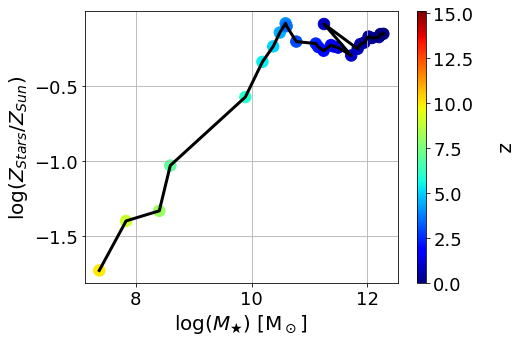

In [29]:
fig,ax=plt.subplots(figsize=(7,5))
    
# Plot main branch
ax.plot(xplot_main,yplot_main,c='k',lw=3)
sc_main=ax.scatter(xplot_main,yplot_main,c=color_plot_main,s=130)

# Vertical color bar with reference to redshifts
sc_main.set_cmap('jet')
sc_main.set_norm(norm)
cbar=fig.colorbar(sc_main, ax=ax, orientation='vertical',shrink=1,pad=0.05,aspect=30)
cbar.set_label(color_var_label,fontsize=20,rotation=270,labelpad=40)
cbar.ax.tick_params(axis='both', which='major', labelsize=18,top=True,bottom=False,
                    labeltop=True,labelbottom=False)

ax.grid()

xmin, xmax = -0.3,8.3
#ax.set_xlim(xmax,xmin)

ymin, ymax= 6.4,10.6
#ax.set_ylim(ymin,ymax)

ax.set_xlabel(xlabel,fontsize=20)
ax.set_ylabel(ylabel,fontsize=20)

ax.tick_params(which='major',axis='both',labelsize=18)

# plt.savefig('merge_tree_principal_log(z_zsun)_vs_log(mass).png')

In [30]:
# Variables to plot
xplot=tree['Redshift']
yplot=tree['SF_logOH']

# Labels of variables to plot
xlabel=r'$z$'
ylabel=r'$12+\log(O/H)$'

# Variables a graficar, solo de la main branch
xplot_main=xplot[mask_main]
yplot_main=yplot[mask_main]
color_plot_main=color_plot[mask_main]

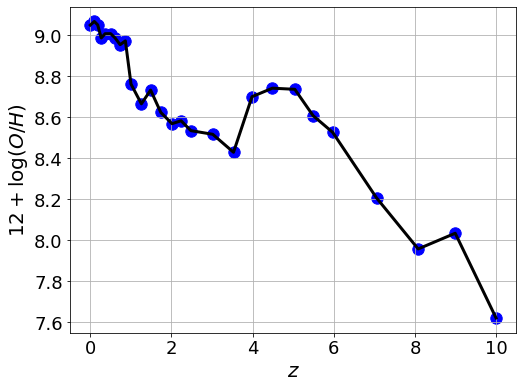

In [31]:
fig,ax=plt.subplots(figsize=(8,6))
    
# Plot main branch
ax.plot(xplot_main,yplot_main,c='k',lw=3)
sc_main=ax.scatter(xplot_main,yplot_main,c='b',s=130)


ax.grid()

xmin, xmax = -0.3,8.3
#ax.set_xlim(xmax,xmin)

ymin, ymax= 6.4,10.6
#ax.set_ylim(ymin,ymax)

ax.set_xlabel(xlabel,fontsize=20)
ax.set_ylabel(ylabel,fontsize=20)

ax.tick_params(which='major',axis='both',labelsize=18)

# plt.savefig('merge_tree_principal_metalicidad_vs_z.png')

In [32]:
# Variables to plot
xplot=tree['Redshift']
yplot=np.log10(tree['Stars_Metallicity'])-np.log10(0.02)

# Labels of variables to plot
xlabel=r'$z$'
ylabel=r'$\log(Z_{Stars}/Z_{Sun})$'

# Variables a graficar, solo de la main branch
xplot_main=xplot[mask_main]
yplot_main=yplot[mask_main]
color_plot_main=color_plot[mask_main]

<ipython-input-32-10ba7595e178>:3: RuntimeWarning: divide by zero encountered in log10
  yplot=np.log10(tree['Stars_Metallicity'])-np.log10(0.02)


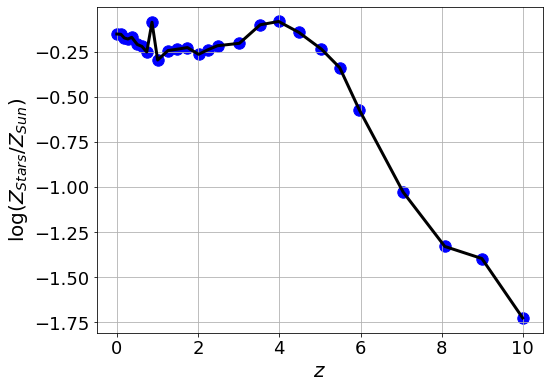

In [33]:
fig,ax=plt.subplots(figsize=(8,6))
    
# Plot main branch
ax.plot(xplot_main,yplot_main,c='k',lw=3)
sc_main=ax.scatter(xplot_main,yplot_main,c='b',s=130)


ax.grid()

xmin, xmax = -0.3,8.3
#ax.set_xlim(xmax,xmin)

ymin, ymax= 6.4,10.6
#ax.set_ylim(ymin,ymax)

ax.set_xlabel(xlabel,fontsize=20)
ax.set_ylabel(ylabel,fontsize=20)

ax.tick_params(which='major',axis='both',labelsize=18)

# plt.savefig('merge_tree_principal_log(z_zsun)_vs_z.png')

In [38]:
xplot_main=main_branch['SnapNum']
xlabel='SnapNum'

# Calculo level of merger
level_merger=[1]       # Inicializo con un 1, porque la primer galaxia del main branch 
                       # no viene de ninguna fusión...
    
for k in range(np.size(xplot_main)-1):
    m1=main_branch['Stars_Mass'][k]+main_branch['SF_Mass'][k]
    mask=(tree['DescendantID']==main_branch['GalaxyID'][k+1]) & (tree['SnapNum']!=28)
    # La condición de snapnum distinto a 28 es porque galaxias a z=0 no tienen descendiente,
    # y se les asigna como DescendantID su propio GalaxyID
    m2=np.sum(tree['Stars_Mass'][mask])+np.sum(tree['SF_Mass'][mask])
    level=m2/m1
    level_merger=np.append(level_merger,level)  

In [39]:
# Variable a graficar en eje y
yplot_main=level_merger
#yplot_main=np.log10(main_branch['Stars_Mass'])
#yplot_main=np.log10(main_branch['StarFormationRate'])

ylabel=r'$L_{\rm{merger}}$'
#ylabel=r'$\log(M_\bigstar)~[\rm{M}_\odot]$'
#ylabel=r'$\log(SFR)~[\rm{M}_\odot~\rm{yr}^{-1}]$'


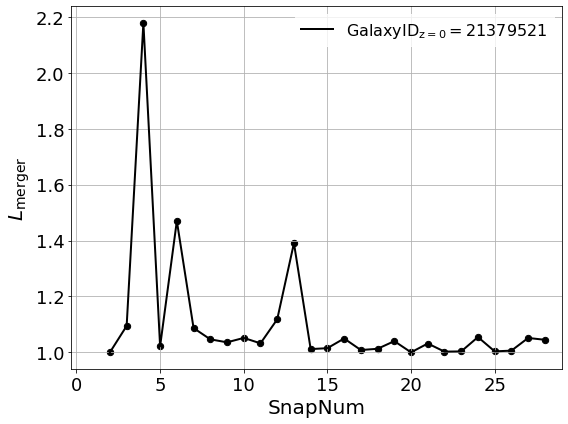

In [44]:
# Graficar level of merger vs. redshift

fig2,ax2=plt.subplots(figsize=(8,6))
#ax2.set_xlim(4.1,-0.1)
ax2.plot(xplot_main,yplot_main,c='k',lw=2,
         label=r'$\rm{GalaxyID}_{z=0}=$'+str(galid))
ax2.scatter(xplot_main,yplot_main,color='k',s=40)

ax2.set_xlabel(xlabel,fontsize=20)
ax2.set_ylabel(ylabel,fontsize=20)

ax2.tick_params(which='major',axis='both',labelsize=18)
ax2.grid()
ax2.legend(loc='upper right',fontsize=16,edgecolor='w')

xmin, xmax = -0.3,29
ax2.set_xlim(xmin,xmax)

ymin,ymax=0.95,1.65
#ax2.set_ylim(ymin,ymax)

# Adjust subplots
plt.tight_layout()

# plt.savefig('level_of_merger.png')

In [ ]:
Vemos que la galáxia más masiva sufre varios merger durante toda la simulación. Principalmente tres muy sugnificativos en los redshift al rededor de ocho, seis y tres. 
Siendo el mayor el de ocho, donde se fusiono con galáxias que duplicaron su masa

In [37]:
level_merger

array([1.        , 1.09453297, 2.17916679, 1.02156138, 1.47029734,
       1.08683014, 1.046538  , 1.03581369, 1.05159712, 1.03217375,
       1.11808133, 1.39072347, 1.01156402, 1.0148499 , 1.04947853,
       1.00824332, 1.01267231, 1.04007483, 1.        , 1.03155982,
       1.00247252, 1.00337481, 1.05455494, 1.00351703, 1.00600374,
       1.05140054, 1.0448904 ])